<a href="https://colab.research.google.com/github/tejaspradhan/GANs-Masterclass/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding a Generative Adversarial Network in Tensorflow for the MNIST Dataset

# Importing Libraries

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
import time

# Downloading & Exploring the Dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()  

11501568/11490434 [==============================] - 0s 0us/step


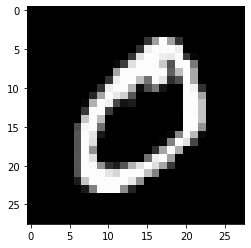

In [4]:
plt.imshow(train_images[1] ,cmap='gray')

## Data Preprocessing

In this, we perform 2 main tasks : 
1. **Normalisation**
  
  Here we perform standard normalisation to bring the pixel values of the images between `-1 and 1`. For this we use the formula 
  
  **`Normalised value = (Given Value - (MaxVal-MinVal/2)) / (MaxVal-MinVal/2)`**
  
  Generally, the pixel values are ranging from `0 to 255`. Computing such huge numbers becomes extremely cumbersome for neural networks and it might lead to the problem of exploding gradients. To avoid this normalization of data is always preferred. We can also perform normalisation using minmax scaler to bring the data in the range of `0 to 1`.

2. **Expanding Dimensions of the Images**

  This step is mainly performed because convolutional neural networks require 1 image in 3-dimensions. So even though are images have only 1 channel (Grayscale), we need to reshape them so that each image has one dimension extra. This is done either by using `expanddims` or `reshape`



In [5]:
# Normalization
train_images= (train_images-127.5)/127.5

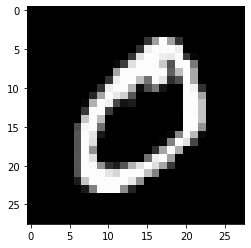

In [6]:
plt.imshow(train_images[1],cmap='gray')

In [8]:
train_images.shape

(60000, 28, 28)

In [9]:
# Expanding dimensions
train_images = train_images.reshape(train_images.shape[0],train_images.shape[1],train_images.shape[2],1)
train_images.shape

(60000, 28, 28, 1)

In [10]:
# Defining training size parameters
BUFFER_SIZE = 60000 # what is the total number of samples to be trained ?
BATCH_SIZE = 256 # how many training samples should the neural network look at - at one point or during one epoch

In [9]:
# Batchwise shuffling of the dataset - to avoid mode collapse and overfitting 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Building The Discriminator 

The discriminator is essentially a binary crossentropy. We define a custom method to return a classifier model with convolutional as well as dense layers and a final Dense neuron. The discriminator can be thought of as a conventional CNN. 

Steps for building the Discriminator 

* Define model layers 
* Define model loss
* Define model optimizer 

**Loss For Discrimintor**: 

The discriminator takes input from the real as well as the fake samples. Loss for the discriminator is therefore, the sum of fake loss and real loss.
In order to pass the ground truth / true values to the loss function we use the `ones_like` and `zeros_like` functions. These two functions take in an array or tensor as an input and output a tensor with the same shape consisting of just ones or zeros

e.g: 

`tf.ones_like([1,2,3,4,5]) => [1,1,1,1,1]`

`tf.zeros_like([1,2,3,4,5]) => [0,0,0,0,0]`

In [10]:
# Essentially a CNN model 
def discriminator():
  model = tf.keras.models.Sequential()
  
  model.add(tf.keras.layers.Conv2D(7,(3,3),padding='same',input_shape=(28,28,1)))
  model.add(tf.keras.layers.Conv2D(7,(3,3),padding='same'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(50,activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  return model

In [11]:
# optimizer for the discriminator
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
# loss function for the discriminator 
def discriminator_loss(real_predictions, fake_predictions):
  # passing both the outputs through a sigmoid activation so as to get the probability values
  real_predictions = tf.sigmoid(real_predictions) 
  fake_predictions = tf.sigmoid(fake_predictions)

  # Computing binary crossentropy loss 
  real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
  fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions),fake_predictions)
  
  # returning final losses
  if real_loss.shape == fake_loss.shape:
    return real_loss+fake_loss
  else:
    return fake_loss+0.1
  

In [15]:
discriminator().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 7)         70        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 7)         448       
_________________________________________________________________
flatten (Flatten)            (None, 5488)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                274450    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 275,019
Trainable params: 275,019
Non-trainable params: 0
_________________________________________________________________


## Building the Generator 

The generator is a neural network which takes in a random noise input and produces an output which is extremely similar to the real data. In this problem the output should be a `28x28` image. The input to the generator is a tensor of 100 random numbers.

The generator follows a process of upsampling, i.e., generating `784 pixels` from 100 input values which are then rescaled to a `28x28` image. 

In [13]:
def generator():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256,input_shape =(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(7*7*256))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Reshape( (7,7,256) ))
  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same'))
  return model

In [14]:
generator().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             157364480 
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         5

In [ ]:
def generator_loss(fake_predictions):
  fake_predictions = tf.sigmoid(fake_predictions)
  fake_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
  return fake_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
generator_model= generator()
discriminator_model = discriminator()

## Training the GAN
Training the GAN involves the following steps 
  1. Training the Discriminator
    
    a. Passing real and fake data through the discriminator.

    b. Calculating the discriminator loss

    c. Passing this loss through the optimiser.

  2. Training the Generator

    a. Passing fake data through the generator.

    b. Calculating generator loss

    c. Passing this loss through the optimiser

In [ ]:
def train(data, epochs):
  for i in range(epochs):
    for images in data:
      images = tf.cast(images,tf.dtypes.float32)
      train_step(images)

In [ ]:
def train_step(images):
  noise = np.random.randn(BATCH_SIZE, 100).astype('float32')
  # batchwise training 
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        # Create fake images 
        generated_images = generator_model(noise)
        # Pass fake images through the discriminator 
        generator_output = discriminator_model(generated_images)
        # Pass real images through the discriminator 
        real_output = discriminator_model(images)

        # calculate individual losses
        gen_loss = generator_loss(generator_output)
        disc_loss = discriminator_loss(real_output, generator_output)
        
        # Calculate gradients of loss functions
        generator_gradients= generator_tape.gradient(gen_loss,generator_model.trainable_variables)
        discriminator_gradients = discriminator_tape.gradient(disc_loss, discriminator_model.trainable_variables)
        
        # Optimise
        generator_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))
        
        print("Generator Loss: ",np.mean(gen_loss))
        print("Discriminator Loss: ",np.mean(disc_loss))



In [ ]:
train(train_dataset,100)

Streaming output truncated to the last 5000 lines.
Generator Loss:  5.1818185
Discriminator Loss:  10.182232
Generator Loss:  5.603595
Discriminator Loss:  9.762966
Generator Loss:  6.206132
Discriminator Loss:  9.164008
Generator Loss:  6.145878
Discriminator Loss:  9.223907
Generator Loss:  5.5433407
Discriminator Loss:  9.82286
Generator Loss:  6.145878
Discriminator Loss:  9.223906
Generator Loss:  6.326639
Discriminator Loss:  9.044219
Generator Loss:  5.603595
Discriminator Loss:  9.762963
Generator Loss:  5.3625793
Discriminator Loss:  10.002544
Generator Loss:  5.784356
Discriminator Loss:  9.583279
Generator Loss:  5.3625793
Discriminator Loss:  10.002548
Generator Loss:  6.085624
Discriminator Loss:  9.2838
Generator Loss:  5.3625793
Discriminator Loss:  10.002545
Generator Loss:  5.7843556
Discriminator Loss:  9.583276
Generator Loss:  5.302326
Discriminator Loss:  10.06244
Generator Loss:  6.266385
Discriminator Loss:  9.104116
Generator Loss:  5.242072
Discriminator Loss: 

KeyboardInterrupt: ignored

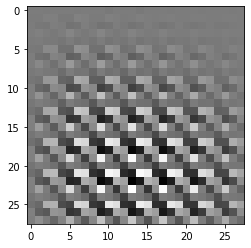

In [ ]:
test_image_noise = np.random.randn(1,100)
generated_test_image = generator_model(test_image_noise)
plt.imshow(tf.reshape(generated_test_image,(28,28)),cmap='gray')

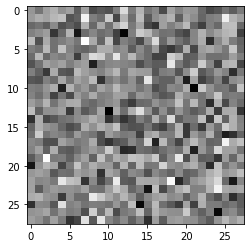

In [ ]:
random_image = np.random.randn(784)
random_image = tf.reshape(random_image,(28,28))
plt.imshow(random_image,cmap='gray')